Sequential Serial Bias
======================



## Notebook Settings



In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

%run ../notebooks/setup.py
%matplotlib inline
%config InlineBackend.figure_format = 'png'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Python exe
/home/leon/mambaforge/envs/torch/bin/python
<Figure size 600x370.82 with 0 Axes>

## Imports



In [1]:
import sys
sys.path.insert(0, '../')

import torch
import gc
import pandas as pd
import numpy as np
from time import perf_counter
from scipy.stats import binned_statistic

from src.network import Network
from src.decode import decode_bump_torch
from src.utils import clear_cache

## Helpers



In [1]:
def convert_seconds(seconds):
    h = seconds // 3600
    m = (seconds % 3600) // 60
    s = seconds % 60
    return h, m, s

## Configuration



In [1]:
REPO_ROOT = '/home/leon/models/NeuroFlame/'
conf_name = 'config_SB.yml'
DEVICE = 'cuda'

## Sequential Serial Bias



### Stimuli sequences



Here we will study how Serial Bias (SB) depends on trial history. So we are going to compute SB over multiple previous trials



In [1]:
N_TRIALS = 10

A trial consist of a stimulation followed by a silencing of the bump after a delay.

First, we define a sequence of stimuli intensities and footprints



In [1]:
# Stimuli strength
I0 = [1.75, -5] * N_TRIALS
print('I0', I0)

# Stimuli footprint
SIGMA0 =  [1, 0] * N_TRIALS
print('SIGMA0', SIGMA0)

I0 [1.75, -5, 1.75, -5, 1.75, -5, 1.75, -5, 1.75, -5, 1.75, -5, 1.75, -5, 1.75, -5, 1.75, -5, 1.75, -5]
SIGMA0 [1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]

Then, we create a sequence of stimuli onsets and offsets



In [1]:
a = [1 + i * 3.5 for i in range(N_TRIALS)]
b = [3 + i * 3.5 for i in range(N_TRIALS)]

T_STIM_ON = [val for pair in zip(a, b) for val in pair]

print(T_STIM_ON)

[1.0, 3.0, 4.5, 6.5, 8.0, 10.0, 11.5, 13.5, 15.0, 17.0, 18.5, 20.5, 22.0, 24.0, 25.5, 27.5, 29.0, 31.0, 32.5, 34.5]

In [1]:
c = [2 + i * 3.5 for i in range(N_TRIALS)]
d = [3.5 + i * 3.5 for i in range(N_TRIALS)]


T_STIM_OFF = [val for pair in zip(c, d) for val in pair]
print(T_STIM_OFF)

DURATION = T_STIM_OFF[-1] + 1
print(DURATION)

[2.0, 3.5, 5.5, 7.0, 9.0, 10.5, 12.5, 14.0, 16.0, 17.5, 19.5, 21.0, 23.0, 24.5, 26.5, 28.0, 30.0, 31.5, 33.5, 35.0]
36.0

### Phase Batches



Now, we need to create batches of stimuli phases to simulate to compute SB.

Let's batch the phases!



In [1]:
N_BATCH = 512

PHI0 = torch.ones((1, 2 * N_TRIALS), device=DEVICE)
PHI0 = PHI0.unsqueeze(-1).repeat((N_BATCH, 1, 1))

# for each stimulus we generate a set of random locations in degrees
for i in range(PHI0.shape[1]):
    PHI0[:, i] = torch.randint(0, 360, (N_BATCH,), device=DEVICE).unsqueeze(1)

print('PHI0', PHI0.shape)
# PHI0 should be of size (N_BATCH, N_STIMULI, 1) the last dimension is there for safety reasons

PHI0 torch.Size([512, 20, 1])

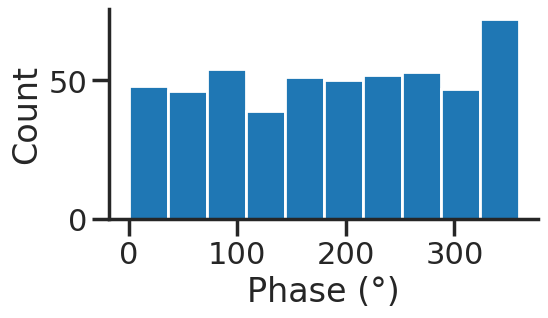

In [1]:
plt.hist(PHI0[:, 0, 0].cpu().numpy())
plt.xlabel('Phase (°)')
plt.ylabel('Count')
plt.show()

### Model



In [1]:
model = Network(conf_name, REPO_ROOT, IF_STP=1, VERBOSE=0, LIVE_FF_UPDATE=1,
                N_BATCH=N_BATCH, DURATION=DURATION,
                I0=I0, SIGMA0=SIGMA0, PHI0=PHI0,
                T_STIM_ON=T_STIM_ON, T_STIM_OFF=T_STIM_OFF,
                TAU_FAC= 1,
                J_STP=7.5)

### Simulations



Let's run the simulation!



In [1]:
rates = model()

### SB analysis



Let's decode the bumps!



In [1]:
m0, m1, phi = decode_bump_torch(rates)
print(m0.shape)

torch.Size([512, 361])

In [1]:
targets = PHI0[:,::2,0].cpu().numpy() * np.pi / 180

In [1]:
steps = np.arange(0, model.N_STEPS - model.N_STEADY, model.N_WINDOW)

mask = 0
for i in range(0, 2 * N_TRIALS, 2):
        mask = mask | (steps == (model.N_STIM_OFF[i] + 9 * model.N_WINDOW - model.N_STEADY))

idx = np.where(mask)[0]

print(idx)

phi_off = phi[:, idx].cpu().numpy()
print('delay phase', phi_off.shape)

print(targets[0, 0] * 180 / np.pi, phi_off[0,0] *180/np.pi)

[ 29  64  99 134 169 204 239 274 309 344]
delay phase (512, 10)
106.000000672989 111.73899882120052

In [1]:
errors =  targets - phi_off
print(errors[0, 0])
errors = (errors + np.pi) % (2.0*np.pi) - np.pi

print('errors', errors.shape)

-0.10016441
errors (512, 10)

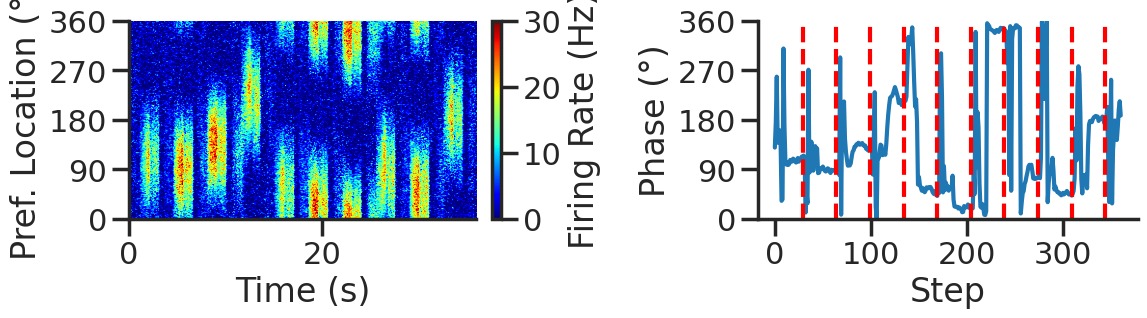

In [1]:
fig, ax = plt.subplots(1, 2, figsize=(2*width, height))
r_max = 30

ax[0].imshow(rates[0].T.cpu().numpy(), aspect='auto',
             cmap='jet', vmin=0, vmax=r_max,
             origin='lower', extent=[0, model.DURATION, 0, model.N_NEURON* model.frac[0]])

ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Pref. Location (°)')
ax[0].set_yticks(np.linspace(0, model.Na[0].cpu(), 5), np.linspace(0, 360, 5).astype(int))

cbar = plt.colorbar(ax[0].images[0], ax=ax[0], fraction=0.046, pad=0.04)
cbar.set_label('Firing Rate (Hz)')

ax[1].plot(phi[0].T.cpu().numpy() * 180 / np.pi, alpha=1)

# for i in range(targets.shape[1]):
#    ax[1].axhline(targets[0, i] * 180.0 / np.pi, 0, model.DURATION, color='k', ls='--')

for i in range(targets.shape[1]):
   ax[1].axvline(idx[i], 0, 360, color='r', ls='--')

ax[1].set_ylabel('Phase (°)')
ax[1].set_xlabel('Step')
ax[1].set_ylim([0, 360])
ax[1].set_yticks(np.linspace(0, 360, 5).astype(int))
plt.show()

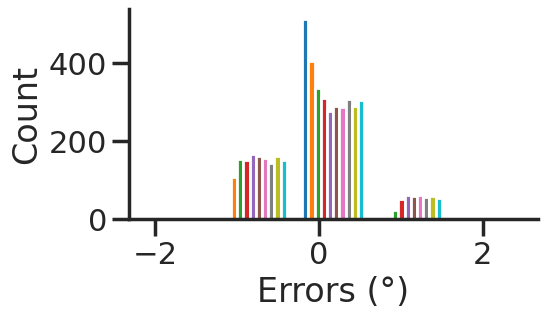

In [1]:
plt.hist(errors, bins=5)
plt.xlabel('Errors (°)')
plt.ylabel('Count')
plt.show()

In [1]:
rel_loc = np.diff(targets, axis=1)
rel_loc = (rel_loc + np.pi ) % (2*np.pi) - np.pi
print(rel_loc.shape)

(512, 9)

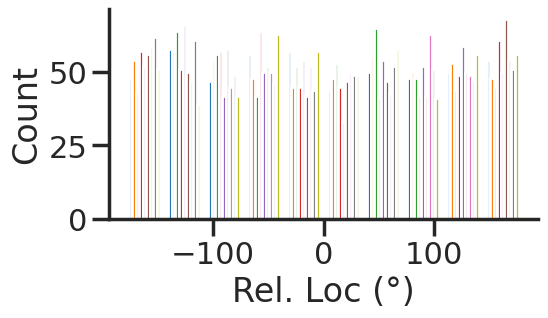

In [1]:
plt.hist(rel_loc *180 /np.pi)
plt.xlabel('Rel. Loc (°)')
plt.ylabel('Count')
plt.show()

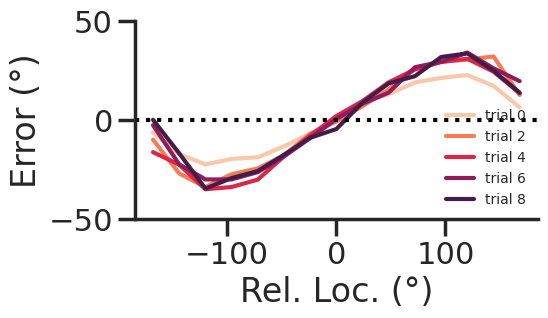

In [1]:
pal = sns.color_palette("rocket_r", n_colors= N_TRIALS)

for i in range(0, rel_loc.shape[1], 2):
    stt = binned_statistic(rel_loc[:, i] * 180 / np.pi,
                           errors[:, i+1] * 180 / np.pi,
                           statistic='mean',
                           bins=15, range=[-180, 180])

    dstt = np.mean(np.diff(stt.bin_edges))
    # plt.plot(rel_loc[:, i]* 180 / np.pi, errors[:, i+1] * 180 / np.pi , 'o', alpha=.25, color=pal[i])
    plt.plot(stt.bin_edges[:-1]+dstt/2,stt.statistic, color=pal[i], label='trial %d' % i, alpha=1)

plt.axhline(color='k', linestyle=":")
plt.xlabel('Rel. Loc. (°)')
plt.ylabel('Error (°)')
plt.ylim([-50, 50])
plt.legend(frameon=False, loc='best', fontsize=10)
plt.show()